In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.mlab as mpll
import matplotlib as mpl
import pathlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import chi2_contingency
from scipy import signal as sp
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import stats as st
import statistics
import math
from scipy.interpolate import UnivariateSpline # para interpolar
from scipy.signal import find_peaks
plt.rcParams["font.family"] = "serif"
from scipy.stats import chi2

# **Cargado de datos**

In [ ]:
def cargar_datos_csv(archivo):
    data = pd.read_csv(archivo, skiprows=1, delimiter=",", decimal=".", header=None)
    entrada = np.asarray(data[0]) #generador
    salida = np.asarray(data[1]) #lock in
    degrees = np.asarray(data[2])
    sensitivity = np.asarray(data[3])
    time_constant = np.asarray(data[4])
    error_Vin = np.asarray(data[6])
    error_V = np.asarray(data[7])
    return entrada, salida, error_Vin, error_V

In [ ]:
V0_1, V_1, error_V0_1, error_V_1 = cargar_datos_csv("Clase 1 - Voltajes - Hoja 1.csv")

In [ ]:
def cargar_datos_txt(archivo):
    data = pd.read_csv(archivo, skiprows=1, delimiter=",", decimal=".", header=None)
    entrada = np.asarray(data[0]) #generador
    salida = np.asarray(data[3])
    return entrada, salida

In [ ]:
V0_2, V_2 = cargar_datos_txt("medicion_volt322025.txt")

In [ ]:
V0_3, V_3 = cargar_datos_txt("medicion_100Hzbarridovolt.txt")

# **Ajustes**

In [ ]:
print(V0_1, V_1)

[0.01 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ] [7.3540e-06 2.7210e-05 4.5460e-05 7.4150e-05 1.0175e-04 1.5174e-04
 1.6288e-04 1.8439e-04 2.0460e-04 2.9090e-04 3.0860e-04]


Resistencia del alambre (Re): 0.5588 Ω ± 0.0457 Ω
Chi-cuadrado (χ²): 842.5700
Grados de libertad (ν): 10
Chi-cuadrado reducido (χ²/ν): 84.2570
p-valor: 0.0000


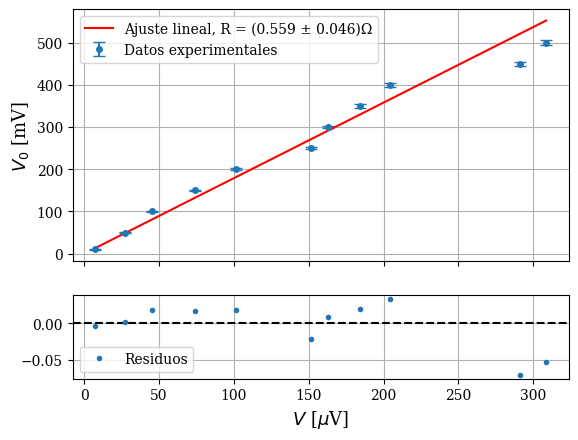

In [ ]:
#Medicion a 20kHz
V0_1 = V0_1 * 1e-3  # mV a V
V_1 = V_1 * 1e-6  # uV a V
error_V_1 = error_V_1 * 1e-6  # uV a V
error_V0_1 = error_V0_1 * 1e-3  # mV a V

# Ajuste V0 = R0/Re * V
def ajuste(V, m):
    return m * V

# Ajuste por mínimos cuadrados ponderados
popt, pcov = curve_fit(ajuste, V_1, V0_1, sigma=error_V0_1, absolute_sigma=True)

m_optimo = popt[0]
Re = (1 / m_optimo) * 1000  # Conversión a ohmios
error_R0_multim = 0.010/100 * 1000.37 + 0.001/100 * 1000
error_Re = np.sqrt(((1/m_optimo) * error_R0_multim)**2 + ((1000.37/(m_optimo**2)) * np.sqrt(pcov[0, 0])))

# Cálculo de estadísticas del ajuste
y_predicho = ajuste(V_1, m_optimo)
residuos = V0_1 - y_predicho
chi2_valor = np.sum((residuos / error_V0_1) ** 2)
dof = len(V_1) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Imprimir resultados
print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Graficar los resultados con barras de error
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V_1 * 1e6, V0_1 * 1e3, yerr=error_V0_1 * 1e3, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V_1 * 1e6, y_predicho * 1e3, 'r-', label=f'Ajuste lineal, R = ({Re:.3f} ± {error_Re:.3f})Ω')
ax[1].errorbar(V_1 * 1e6, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V$ [$\mu$V]', fontsize=13)
ax[0].set_ylabel('$V_0$ [mV]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()


Resistencia del alambre (Re) es: 0.5442 Ω
Resistencia del alambre (Re): 0.5442 Ω ± 0.0001 Ω
Chi-cuadrado (χ²): 1722178701236036456748216235583006924234416969580981983199503581184.0000
Grados de libertad (ν): 10
Chi-cuadrado reducido (χ²/ν): 172217870123603636321211144640522015919858767573886872521982083072.0000
p-valor: 0.0000


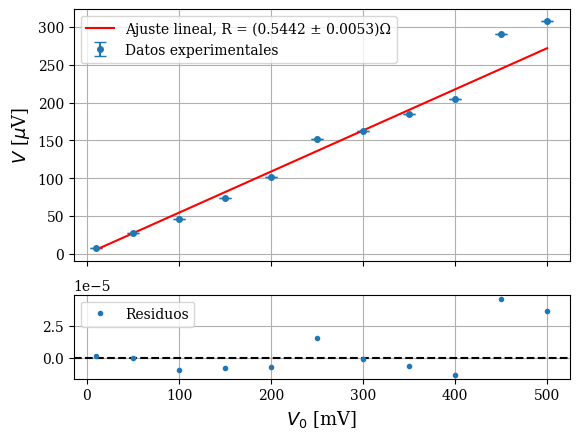

In [ ]:
#Medicion a 20kHz CAMBIO EJE Y
error_V_1 = error_V_1 * 2e-5  # uV a V
error_V0_1 = error_V0_1 * 2e-3  # mV a V

# Ajuste V = R/R0 V0
def ajuste(V0_1, m):
    return m * V0_1

popt, pcov = curve_fit(ajuste, V0_1, V_1, sigma=error_V_1, absolute_sigma=True)

Re = popt[0] * 1000.37

error_R0_multim = 0.010/100*1000.37 + 0.001/100*10000

error_popt = np.sqrt(pcov[0, 0])  # Incertidumbre en el ajuste
error_Re = np.sqrt((1000.37 * error_popt)**2 + (popt[0]*error_R0_multim)**2)

# Imprimir resultados
print(f"Resistencia del alambre (Re) es: {Re:.4f} Ω")
error_V_2 = np.array(error_V_1)
# Graficar los resultados con barras de error
"""
plt.figure(figsize=(10, 5))
plt.errorbar(V0_2*1000, V_2*1000000, yerr=error_V_2*1000000, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
plt.plot(V0_2*1000, ajuste(V0_2, *popt)*1000000, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {error_Re:.4f})Ω')
plt.title('Ajuste lineal V vs $V_0$ - Frec 6kHz ')
plt.xlabel('$V_0$ (mV)')
plt.ylabel('$V$ ($\mu$ V)')
plt.grid(True)
plt.legend()
plt.show()
"""
y_predicho = ajuste(V0_1, popt[0])
residuos = V_1 - y_predicho
chi2_valor = np.sum((residuos / error_V_1) ** 2)
dof = len(V0_1) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V0_1 * 1e3, V_1 * 1e6, yerr=error_V_1 * 1e6, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V0_1 * 1e3, y_predicho * 1e6, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {0.0023})Ω')
ax[1].errorbar(V0_1 * 1e3, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V_0$ [mV]', fontsize=13)
ax[0].set_ylabel('$V$ [$\mu$V]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

Resistencia del alambre (Re) es: 0.2918 Ω


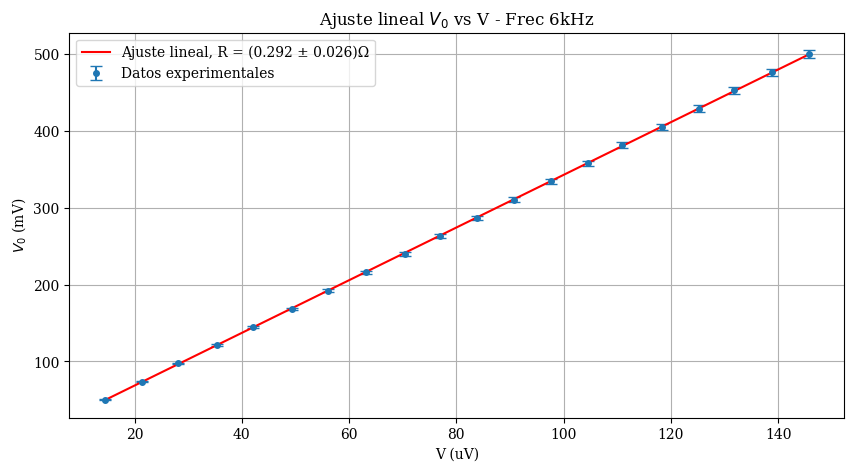

In [ ]:
#Medicion a 6kHz creo
V0_2 = V0_2   # mV a V
V_2 = V_2   # uV a V
error_V_2 = []
error_V0_2 = []

for i in range(len(V_2)):
    error_V_2.append(V_2[i]*0.01+(1/2.28))
    error_V0_2.append(V0_2[i]*0.01)

# Ajuste V0 = R0/Re V
def ajuste(V, m):
    return m * V

popt, pcov = curve_fit(ajuste, V_2, V0_2, sigma=error_V0_2, absolute_sigma=True)

Re = (1 / popt[0]) * 1000
error_R0_multim = 0.010/100*1000.37 + 0.001/100*10000

error_Re = np.sqrt(((1/popt)*error_R0_multim)**2+((1000.37/(popt)**2)*np.sqrt(pcov[0, 0])))[0] #propago los errores de Re=R0/m, faltaria ver que tester usamos para agregar error R0

# Imprimir resultados
print(f"Resistencia del alambre (Re) es: {Re:.4f} Ω")
error_V0_2 = np.array(error_V0_2)
# Graficar los resultados con barras de error
plt.figure(figsize=(10, 5))
plt.errorbar(V_2*1000000, V0_2*1000, yerr=error_V0_2*1000, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
plt.plot(V_2*1000000, ajuste(V_2, *popt)*1000, 'r-', label=f'Ajuste lineal, R = ({Re:.3f} ± {error_Re:.3f})Ω')
plt.title('Ajuste lineal $V_0$ vs V - Frec 6kHz ')
plt.xlabel('V (uV)')
plt.ylabel('$V_0$ (mV)')
plt.grid(True)
plt.legend()
plt.show()

Resistencia del alambre (Re) es: 0.2918 Ω
Resistencia del alambre (Re): 0.2918 Ω ± 0.0013 Ω
Chi-cuadrado (χ²): 0.8970
Grados de libertad (ν): 19
Chi-cuadrado reducido (χ²/ν): 0.0472
p-valor: 1.0000


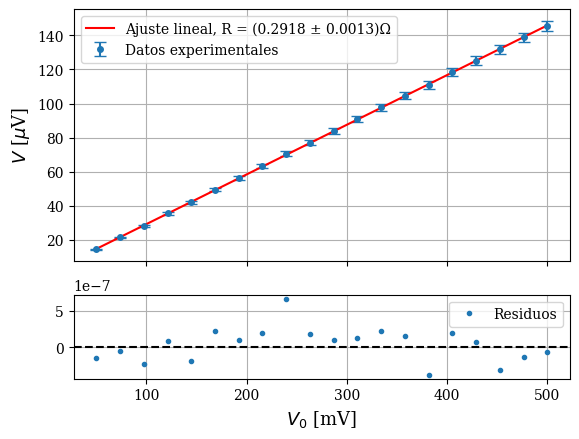

In [ ]:
#Medicion a 6kHz CAMBIO EJE Y
error_V_2 = []
error_V0_2 = []

for i in range(len(V_2)):
    error_V_2.append(V_2[i]*0.02)
    error_V0_2.append(V0_2[i]*0.01)

# Ajuste V = R/R0 V0
def ajuste(V0_2, m):
    return m * V0_2

popt, pcov = curve_fit(ajuste, V0_2, V_2, sigma=error_V_2, absolute_sigma=True)

Re = popt[0] * 1000.37

error_R0_multim = 0.010/100*1000.37 + 0.001/100*10000

error_popt = np.sqrt(pcov[0, 0])  # Incertidumbre en el ajuste
error_Re = np.sqrt((1000.37 * error_popt)**2 + (popt[0]*error_R0_multim)**2)

# Imprimir resultados
print(f"Resistencia del alambre (Re) es: {Re:.4f} Ω")
error_V_2 = np.array(error_V_2)
# Graficar los resultados con barras de error
"""
plt.figure(figsize=(10, 5))
plt.errorbar(V0_2*1000, V_2*1000000, yerr=error_V_2*1000000, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
plt.plot(V0_2*1000, ajuste(V0_2, *popt)*1000000, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {error_Re:.4f})Ω')
plt.title('Ajuste lineal V vs $V_0$ - Frec 6kHz ')
plt.xlabel('$V_0$ (mV)')
plt.ylabel('$V$ ($\mu$ V)')
plt.grid(True)
plt.legend()
plt.show()
"""
y_predicho = ajuste(V0_2, popt[0])
residuos = V_2 - y_predicho
chi2_valor = np.sum((residuos / error_V_2) ** 2)
dof = len(V0_2) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V0_2 * 1e3, V_2 * 1e6, yerr=error_V_2 * 1e6, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V0_2 * 1e3, y_predicho * 1e6, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {error_Re:.4f})Ω')
ax[1].errorbar(V0_2 * 1e3, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V_0$ [mV]', fontsize=13)
ax[0].set_ylabel('$V$ [$\mu$V]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

In [ ]:
print(V0_2, V_2)

[0.05       0.07368421 0.09736842 0.12105263 0.14473684 0.16842105
 0.19210526 0.21578947 0.23947368 0.26315789 0.28684211 0.31052632
 0.33421053 0.35789474 0.38157895 0.40526316 0.42894737 0.45263158
 0.47631579 0.5       ] [1.44365e-05 2.14522e-05 2.81838e-05 3.54035e-05 4.20457e-05 4.93585e-05
 5.61478e-05 6.31479e-05 7.05277e-05 7.69612e-05 8.37860e-05 9.07262e-05
 9.77186e-05 1.04562e-04 1.10947e-04 1.18420e-04 1.25208e-04 1.31742e-04
 1.38828e-04 1.45809e-04]


Resistencia del alambre (Re): 0.2918 Ω ± 0.0255 Ω
Chi-cuadrado (χ²): 3.5731
Grados de libertad (ν): 19
Chi-cuadrado reducido (χ²/ν): 0.1881
p-valor: 1.0000


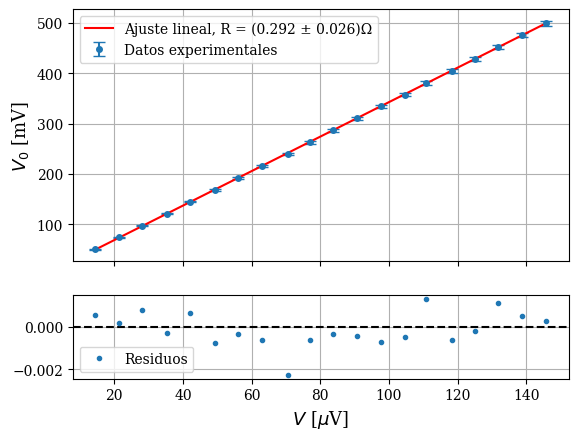

In [ ]:
#Medicion a 6kHz creo
V0_2 = V0_2   # mV a V
V_2 = V_2   # uV a V
error_V_2 = []
error_V0_2 = []

for i in range(len(V_2)):
    error_V_2.append(V_2[i]*0.01+(1/2.28))
    error_V0_2.append(V0_2[i]*0.01)

error_V0_2 = np.array(error_V0_2)

# Ajuste V0 = R0/Re V
def ajuste(V, m):
    return m * V

# ajuste por mínimos cuadrados ponderados
popt, pcov = curve_fit(ajuste, V_2, V0_2, sigma=error_V0_2, absolute_sigma=True)
m_optimo = popt[0]
Re = (1 / popt[0]) * 1000
error_R0_multim = 0.010/100 * 1000.37 + 0.001/100 * 1000
error_Re = np.sqrt(((1/popt)*error_R0_multim)**2 + ((1000.37/(popt)**2) * np.sqrt(pcov[0, 0])))[0]

# cálculo cositas
y_predicho = ajuste(V_2, m_optimo)
residuos = V0_2 - y_predicho
chi2_valor = np.sum((residuos / error_V0_2) ** 2)
dof = len(V_2) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V_2 * 1e6, V0_2 * 1e3, yerr=error_V0_2 * 1e3, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V_2 * 1e6, y_predicho * 1e3, 'r-', label=f'Ajuste lineal, R = ({Re:.3f} ± {error_Re:.3f})Ω')
ax[1].errorbar(V_2 * 1e6, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V$ [$\mu$V]', fontsize=13)
ax[0].set_ylabel('$V_0$ [mV]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()


Resistencia del alambre (Re): 0.4969 Ω ± 0.0334 Ω
Chi-cuadrado (χ²): 370.3235
Grados de libertad (ν): 19
Chi-cuadrado reducido (χ²/ν): 19.4907
p-valor: 0.0000


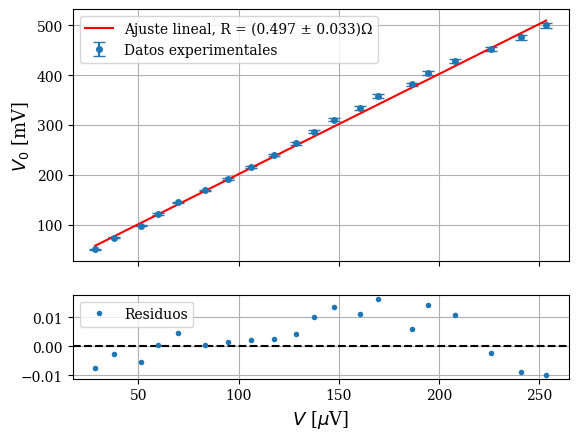

In [ ]:
#Medicion a 100Hz
V0_3 = V0_3   # mV a V
V_3 = V_3   # uV a V
error_V_3 = []
error_V0_3 = []

for i in range(len(V_3)):
    error_V_3.append(V_3[i]*0.01+(1/2.28))
    error_V0_3.append(V0_3[i]*0.01)

error_V0_3 = np.array(error_V0_3)

# Ajuste V0 = R0/Re * V
def ajuste(V, m):
    return m * V

# Ajuste por mínimos cuadrados ponderados
popt, pcov = curve_fit(ajuste, V_3, V0_3, sigma=error_V0_3, absolute_sigma=True)

m_optimo = popt[0]
Re = (1 / m_optimo) * 1000  # Conversión a ohmios
error_R0_multim = 0.010/100 * 1000.37 + 0.001/100 * 1000
error_Re = np.sqrt(((1/m_optimo) * error_R0_multim)**2 + ((1000.37/(m_optimo**2)) * np.sqrt(pcov[0, 0])))

# Cálculo de estadísticas del ajuste
y_predicho3 = ajuste(V_3, m_optimo)
residuos = V0_3 - y_predicho3
chi2_valor = np.sum((residuos / error_V0_3) ** 2)
dof = len(V_3) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Imprimir resultados
print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Graficar los resultados con barras de error
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V_3 * 1e6, V0_3 * 1e3, yerr=error_V0_3 * 1e3, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V_3 * 1e6, y_predicho3 * 1e3, 'r-', label=f'Ajuste lineal, R = ({Re:.3f} ± {error_Re:.3f})Ω')
ax[1].errorbar(V_3 * 1e6, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V$ [$\mu$V]', fontsize=13)
ax[0].set_ylabel('$V_0$ [mV]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

Resistencia del alambre (Re) es: 0.4945 Ω
Resistencia del alambre (Re): 0.4945 Ω ± 0.0011 Ω
Chi-cuadrado (χ²): 316.0150
Grados de libertad (ν): 19
Chi-cuadrado reducido (χ²/ν): 16.6324
p-valor: 0.0000


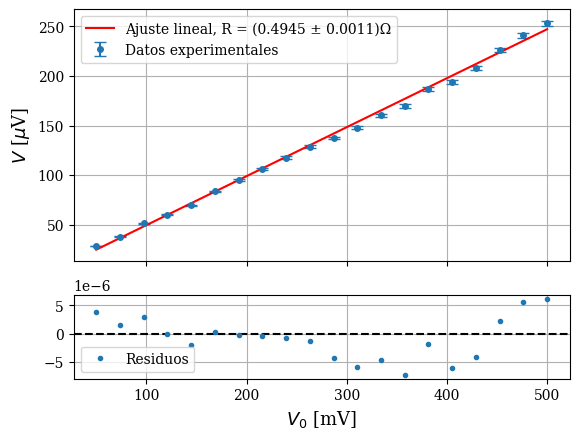

In [ ]:
#Medicion a 100Hz CAMBIO EJE Y
#Medicion a 100Hz
V0_3 = V0_3   # mV a V
V_3 = V_3   # uV a V
error_V_3 = []
error_V0_3 = []

for i in range(len(V_3)):
    error_V_3.append(V_3[i]*0.01)
    error_V0_3.append(V0_3[i]*0.01)
# Ajuste V = R/R0 V0

def ajuste(V0_3, m):
    return m * V0_3

popt, pcov = curve_fit(ajuste, V0_3, V_3, sigma=error_V_3, absolute_sigma=True)

Re = popt[0] * 1000.37

error_R0_multim = 0.010/100*1000.37 + 0.001/100*10000

error_popt = np.sqrt(pcov[0, 0])  # Incertidumbre en el ajuste
error_Re = np.sqrt((1000.37 * error_popt)**2 + (popt[0]*error_R0_multim)**2)

# Imprimir resultados
print(f"Resistencia del alambre (Re) es: {Re:.4f} Ω")
error_V_3 = np.array(error_V_3)
# Graficar los resultados con barras de error
"""
plt.figure(figsize=(10, 5))
plt.errorbar(V0_2*1000, V_2*1000000, yerr=error_V_2*1000000, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
plt.plot(V0_2*1000, ajuste(V0_2, *popt)*1000000, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {error_Re:.4f})Ω')
plt.title('Ajuste lineal V vs $V_0$ - Frec 6kHz ')
plt.xlabel('$V_0$ (mV)')
plt.ylabel('$V$ ($\mu$ V)')
plt.grid(True)
plt.legend()
plt.show()
"""
y_predicho = ajuste(V0_3, popt[0])
residuos = V_3 - y_predicho
chi2_valor = np.sum((residuos / error_V_3) ** 2)
dof = len(V0_3) - len(popt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"Resistencia del alambre (Re): {Re:.4f} Ω ± {error_Re:.4f} Ω")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Grados de libertad (ν): {dof}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(V0_3 * 1e3, V_3 * 1e6, yerr=error_V_3 * 1e6, fmt='o', label='Datos experimentales', capsize=4, markersize=4)
ax[0].plot(V0_3 * 1e3, y_predicho * 1e6, 'r-', label=f'Ajuste lineal, R = ({Re:.4f} ± {error_Re:.4f})Ω')
ax[1].errorbar(V0_3 * 1e3, residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('$V_0$ [mV]', fontsize=13)
ax[0].set_ylabel('$V$ [$\mu$V]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()